# Chest X-Ray Medical Diagnosis with Deep Learning

<a name='1'></a>
## 1. Import Packages and Functions¶



In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from os import listdir
from os.path import join, isfile, isdir
from glob import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from PIL import Image
sns.set()
from tqdm import tqdm
%matplotlib inline

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [4]:
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.compat.v1.logging import INFO, set_verbosity

random.seed(a=None, version=2)
#The random.seed() function is a method in Python's random module that initializes the random number generator with a given seed value. 
#It allows you to generate a sequence of random numbers that can be replicated or reproduced in future runs, as long as the same seed value is used.


def get_roc_curve(labels, predicted_vals, generator):
    auc_roc_vals = []
    optimal_thresholds = []
    sensitivity = []
    specificity = []
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for i in range(len(labels)):
        try:
            gt = generator.labels[:, i] 
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred) # return 
            auc_roc_vals.append(auc_roc)
            fpr, tpr, thresholds = roc_curve(gt, pred)
            optimal_idx = np.argmax(tpr - fpr)
            optimal_threshold = thresholds[optimal_idx]
            y_pred = pred > optimal_threshold
            acc = accuracy_score(gt, y_pred)
            prec = precision_score(gt, y_pred)
            rec = recall_score(gt, y_pred)
            f1_s = f1_score(gt, y_pred)
            accuracy.append(acc)
            precision.append(prec)
            recall.append(rec)
            f1.append(f1_s)
            optimal_thresholds.append(optimal_threshold) # find optimal thresholds https://stats.stackexchange.com/questions/123124/how-to-determine-the-optimal-threshold-for-a-classifier-and-generate-roc-curve
            optimal_tpr = round(tpr[optimal_idx],3)
            optimal_1_fpr = round(1 - fpr[optimal_idx],3)
#             print(f"Length of tpr tpr : {len(tpr)} \n Length of thresholds {len(thresholds)}")
#             print(f"optimal index : {optimal_idx} \n Optimal 1 - fpr : {optimal_1_fpr}")
            sensitivity.append(optimal_tpr)
            specificity.append(1-fpr[optimal_idx])
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--') # black dash line
            plt.plot(fpr, tpr,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals, optimal_thresholds, sensitivity, specificity, accuracy, precision, recall, f1



In [5]:
#test_df = pd.read_csv("../input/nih-chest-xray-dataset/test.csv")
#test_df.head()
all_xray_df = pd.read_csv("../input/chestxray8-dataframe/train_df.csv")
all_xray_df.drop(['No Finding'], axis = 1, inplace = True)
all_xray_df.head()

data_dir1 = '../input/data/'
data_dir2 = '../input/chestxray8-dataframe/'
train_df = pd.read_csv(data_dir1 + 'Data_Entry_2017.csv')
image_label_map = pd.read_csv(data_dir2 + 'train_df.csv')
bad_labels = pd.read_csv(data_dir2 + 'cxr14_bad_labels.csv')

# Listing all the .jpg filepaths
image_paths = glob(data_dir1+'images_*/images/*.png')
print(f'Total image files found : {len(image_paths)}')
print(f'Total number of image labels: {image_label_map.shape[0]}')
print(f'Unique patients: {len(train_df["Patient ID"].unique())}')

image_label_map.drop(['No Finding'], axis = 1, inplace = True)
labels = image_label_map.columns[2:-1]
labels


Total image files found : 112120
Total number of image labels: 111863
Unique patients: 30805


Index(['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration',
       'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax', 'Pleural_Thickening',
       'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation'],
      dtype='object')

In [6]:
all_xray_df = all_xray_df[89485:] # 22378 images

In [7]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [8]:
train_df.rename(columns={"Image Index": "Index"}, inplace = True)
image_label_map.rename(columns={"Image Index": "Index"}, inplace = True)
train_df = train_df[~train_df.Index.isin(bad_labels.Index)]
train_df.shape

Index =[]
for path in image_paths:
    Index.append(path.split('/')[5])
index_path_map = pd.DataFrame({'Index':Index, 'FilePath': image_paths})
index_path_map.head()

# Merge the absolute path of the images to the main dataframe
pd.merge(train_df, index_path_map, on='Index', how='left')

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
111858,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
111859,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
111860,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
111861,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


In [9]:
dataset = pd.merge(train_df, index_path_map, on='Index', how='left')

In [10]:
IMAGE_SIZE=[256, 256]
EPOCHS = 20
# BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 64

In [11]:
def get_generator(df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    
    print("getting testing generators...")
    
    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return test_generator

train_generator = get_generator(df = image_label_map,
                                      image_dir = None, 
                                      x_col = 'FilePath',
                                      y_cols = labels, 
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

getting testing generators...
Found 111863 validated image filenames.


With our generator function ready, let's make one generator for our training data and one each of our test and  validation datasets.

In [12]:
IMAGE_DIR = ""
test_generator= get_generator(all_xray_df, "", "FilePath", labels)

getting testing generators...
Found 22378 validated image filenames.


<a name='2-6'></a>
### 2.4 Look at the X-rays
Now lets have a look at the original dataset. Here `get_label()` function returns the concatenated version of the names of the diagnosis categories. You can run the following cell multiple times to get more images. 

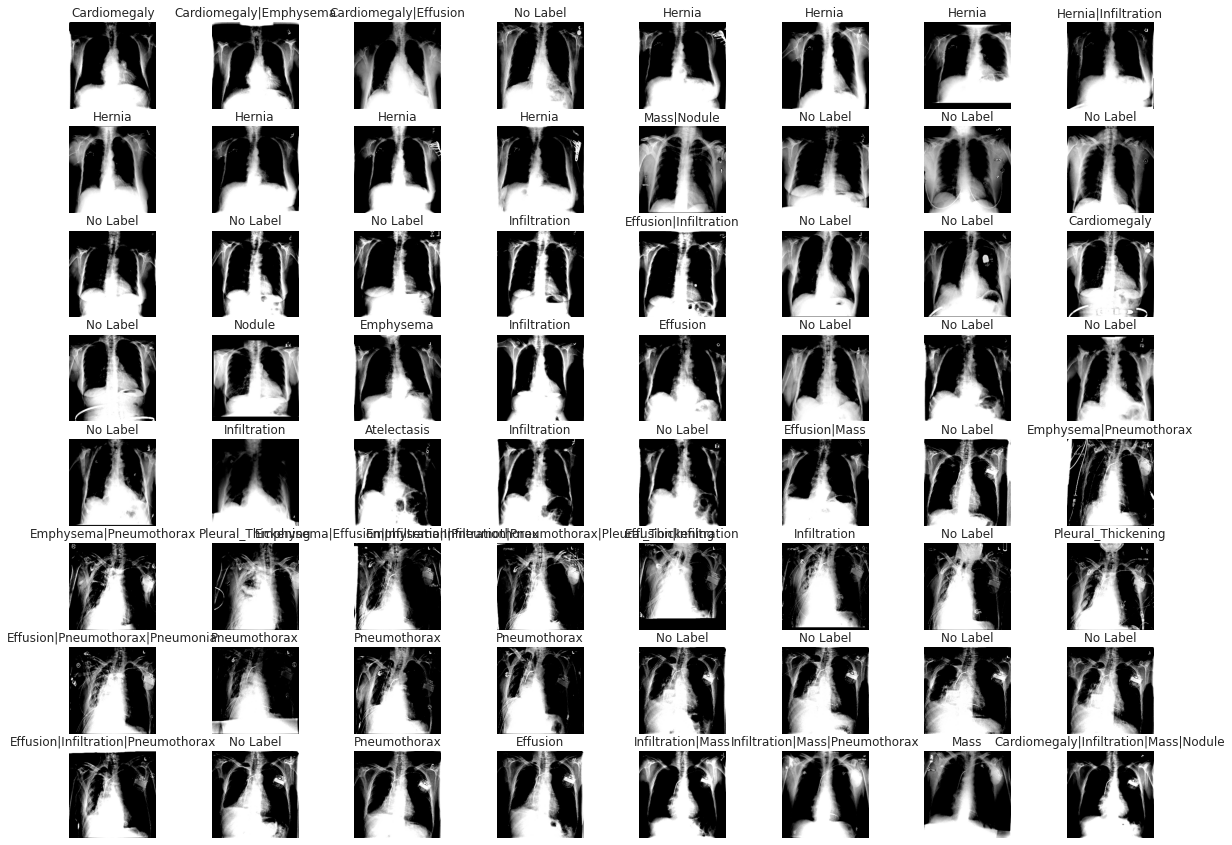

In [13]:
X, Y = train_generator.next()

def get_label(y):

    ret_labels = []
    for idx in range(len(y)):
        if y[idx]: ret_labels.append(labels[idx])
    if len(ret_labels):  return '|'.join(ret_labels)
    else: return 'No Label'

rows = int(np.floor(np.sqrt(X.shape[0])))
cols = int(X.shape[0]//rows)
fig = plt.figure(figsize=(20,15))
for i in range(1, rows*cols+1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(X[i-1], cmap='gray')
    plt.title(get_label(Y[i-1]))
    plt.axis(False)
    fig.add_subplot

In [14]:
len(test_generator)

2798

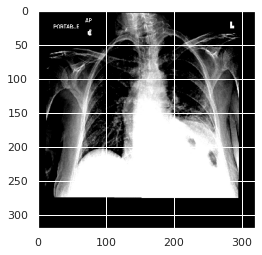

In [15]:
# peek into one item of the test generator
x, y = test_generator.__getitem__(0)
plt.imshow(x[0]);

<a name='2-7'></a>
### 2.5 Diagnosis Distribution (Normal vs Sick)
Now lets have a look at the distribution of the dataset. It is quire evident that almost half of the images didn't have any problem. They are simply the x-rays of healthy people marked as **No Finding** in the data frame. However we can have a look at the number of healthy and non-healthy x-rays.  

In [16]:
import bokeh
import IPython.display as ipd
from bokeh.layouts import column, row
from bokeh.models import ColumnDataSource, LinearAxis, Range1d
from bokeh.models.tools import HoverTool
from bokeh.palettes import BuGn4, cividis
from bokeh.plotting import figure, output_notebook, show, output_file
from bokeh.transform import cumsum
from bokeh.palettes import Category20b

output_notebook()
diagnosis = ['Normal', 'Sick' ]
counts = [(train_df['Finding Labels'] == 'No Finding').sum(), train_df.shape[0]- (train_df['Finding Labels'] == 'No Finding').sum()]
source = ColumnDataSource(pd.DataFrame({'Type':diagnosis,'Counts':counts, 'color':['#054000', '#e22d00']}))

tooltips = [
    ("Category", "@Type"),
    ("No of Samples", "@Counts")
]

normal_vs_sick = figure(x_range=diagnosis, y_range=(0,70000), plot_height=400, plot_width = 400, title="Normal vs Sick Distribution", tooltips = tooltips)
normal_vs_sick.vbar(x='Type', top='Counts', width=0.75, legend_field="Type", color = 'color', source=source)
normal_vs_sick.xgrid.grid_line_color = None
normal_vs_sick.legend.orientation = "vertical"
normal_vs_sick.legend.location = "top_right"
show(normal_vs_sick)




Loading BokehJS ...

In [17]:
data = image_label_map[labels].sum(axis=0).sort_values(ascending = True)

# bokeh packages

diagnosis = data.index.tolist()
source = ColumnDataSource(data=dict(diagnosis=data.index.tolist(), counts=data.tolist(), color = Category20b[len(data)]))

tooltips = [("Diagnosis", "@diagnosis"), ("Count", "@counts") ]
diag_dist = figure(x_range=diagnosis, y_range=(0,15000), plot_height=400, plot_width = 700, title="Diagnosis Distributions", tooltips = tooltips)
diag_dist.vbar(x='diagnosis', top='counts', width=0.65, color='color', legend_field="diagnosis", source=source)

diag_dist.xgrid.grid_line_color = None
diag_dist.legend.orientation = "vertical"
diag_dist.legend.location = "top_left"

# show(diag_dist)




def plot_pie_bokeh(data = None):
    from math import pi
    from bokeh.palettes import Category20c
    x = data.to_dict()

    data = pd.Series(x).reset_index(name='value').rename(columns={'index':'category'})
    data['angle'] = data['value']/data['value'].sum() * 2*pi
    data['color'] = Category20b[len(x)]
    p = figure(plot_height=400, plot_width = 700, title="Pie Chart", tooltips="@category: @value%", x_range=(-0.5, 1.0))
    p.wedge(x=0.38, y=1, radius=0.4, start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="black", fill_color='color', legend_field='category', source=data)

    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None

    p.legend.orientation = "vertical"
    p.legend.location = "top_left"
    
    return p


dist_diag_percent = plot_pie_bokeh(data/data.sum()*100)

show(column(diag_dist, dist_diag_percent))

We observe that among the different identified conditions, **Infiltration, Effusion and Atelectasis** have the highest dominance and **Hernia** has the lowest prevalance. Hernia is very small **(0.28% only)** among the sick patients. However the hightest prevalance **Infiltration** has only **25%** and rest of the 13 classses combines to the rest. So the dataset has highly imbalanced positive class which will in turn create problem of negative bias while training CNN models. 

In [18]:
show(plot_pie_bokeh(data/data.sum()*100))

In [19]:
train_df.rename(columns={"Patient Age": "PatientAge"}, inplace = True)
train_df[train_df['PatientAge'] > 100]

,Index,Finding Labels,Follow-up #,Patient ID,PatientAge,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,0.139,NaN
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,0.139,NaN
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,0.143,NaN
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,0.143,NaN
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,0.143,NaN
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,0.143,NaN
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,0.143,NaN
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,0.143,NaN
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139,NaN
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,0.139,NaN


In [20]:
average_age = int(train_df[train_df['PatientAge'] < 100]['PatientAge'].mean())
for idx in range(train_df.shape[0]):
    if train_df.iloc[idx, 4] > 100:
        print(f'{train_df.iloc[idx, 0]} : age {train_df.iloc[idx, 4]} is changed to ->> {average_age}')
        train_df.iloc[idx, 4] = average_age

train_df[train_df['PatientAge'] > 100]

00005567_000.png : age 412 is changed to ->> 46
00011973_002.png : age 414 is changed to ->> 46
00012238_010.png : age 148 is changed to ->> 46
00013950_000.png : age 148 is changed to ->> 46
00014520_026.png : age 150 is changed to ->> 46
00015558_000.png : age 149 is changed to ->> 46
00018366_044.png : age 152 is changed to ->> 46
00019346_000.png : age 151 is changed to ->> 46
00020900_002.png : age 411 is changed to ->> 46
00021047_002.png : age 412 is changed to ->> 46
00021275_003.png : age 413 is changed to ->> 46
00022811_000.png : age 412 is changed to ->> 46
00025206_000.png : age 153 is changed to ->> 46
00026028_001.png : age 154 is changed to ->> 46
00026871_000.png : age 155 is changed to ->> 46
00027989_000.png : age 155 is changed to ->> 46


,Index,Finding Labels,Follow-up #,Patient ID,PatientAge,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11


In [21]:
def hist_hover(data, column=None,  title = 'Histogram',  colors=["SteelBlue", "Tan"], bins=30, log_scale=False, show_plot=True):

    # build histogram data with Numpy
    hist, edges = np.histogram(data, bins = bins)

    hist_df = pd.DataFrame({column: hist, "left": edges[:-1], "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    # bokeh histogram with hover tool
    if log_scale == True:
        hist_df["log"] = np.log(hist_df[column])
        src = ColumnDataSource(hist_df)
        plot = figure(plot_height = 300, plot_width = 600,
              title = title,
              x_axis_label = column.capitalize(),
              y_axis_label = "Log Count")    
        plot.quad(bottom = 0, top = "log",left = "left", 
            right = "right", source = src, fill_color = colors[0], 
            line_color = "black", fill_alpha = 0.7,
            hover_fill_alpha = 1.0, hover_fill_color = colors[1])
    else:
        src = ColumnDataSource(hist_df)
        plot = figure(plot_height = 300, plot_width = 600,
            title = title,
              x_axis_label = column.capitalize(),
              y_axis_label = "Count")    
        plot.quad(bottom = 0, top = column,left = "left", 
            right = "right", source = src, fill_color = colors[0], 
            line_color = "black", fill_alpha = 0.7,
            hover_fill_alpha = 1.0, hover_fill_color = colors[1])
    # hover tool
    hover = HoverTool(tooltips = [(' Age Interval', '@interval'),
                              ('Sample Count', str("@" +str(column)))])
    plot.add_tools(hover)
    # output
    if show_plot == True:
        show(plot)
    else:
        return plot

In [22]:
hist_hover(train_df['PatientAge'], column = 'PatientAge', bins = 100)

In [23]:
ages_male = train_df.loc[(train_df["Patient Gender"] == 'M'), "PatientAge"].tolist()
ages_female = train_df.loc[(train_df["Patient Gender"] == 'F'), "PatientAge"].tolist()

In [24]:
show(column(hist_hover(ages_male, column = 'MaleAges', title = 'Male Patients Age Histogram', bins = 95, show_plot=False),
            hist_hover(ages_female, column = 'FemaleAges', title = 'Female Patients Age Histogram',  bins = 95, show_plot=False)))

In [25]:
train_df.PatientAge.max() - train_df.PatientAge.min()

94

Now let's test our function with some simple cases. 

In [26]:
# create the base pre-trained model
base_model = DenseNet121(weights='../input/chestxray8-dataframe/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [27]:
model.load_weights("../input/chestxray8-dataframe/pretrained_model.h5")

In [28]:
len(test_generator)

2798

In [29]:
predicted_vals = model.predict(test_generator, steps = len(test_generator), verbose = 1)
# 22378 images with batch size of 8

2798/2798 [==============================] - 484s 170ms/step


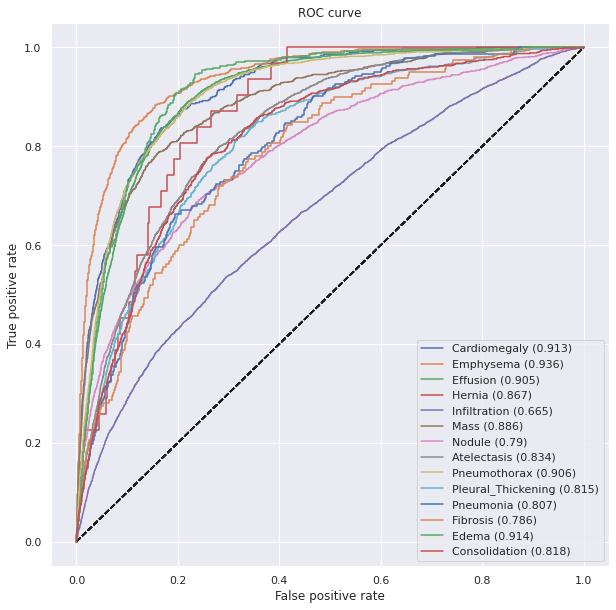

In [30]:
# get roc curve
from statistics import mean
auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1 = get_roc_curve(labels, predicted_vals, test_generator)


In [31]:
# get table of auc_rocs
from tabulate import tabulate
table = zip(labels, auc_rocs)
print(f"Mean AUC : {mean(auc_rocs)}")
print(tabulate(table, headers = ['Pathology', 'AUC'], tablefmt = 'fancy_grid'))

Mean AUC : 0.8458567669362789
╒════════════════════╤══════════╕
│ Pathology          │      AUC │
╞════════════════════╪══════════╡
│ Cardiomegaly       │ 0.912609 │
├────────────────────┼──────────┤
│ Emphysema          │ 0.936044 │
├────────────────────┼──────────┤
│ Effusion           │ 0.904604 │
├────────────────────┼──────────┤
│ Hernia             │ 0.867492 │
├────────────────────┼──────────┤
│ Infiltration       │ 0.665459 │
├────────────────────┼──────────┤
│ Mass               │ 0.886117 │
├────────────────────┼──────────┤
│ Nodule             │ 0.789923 │
├────────────────────┼──────────┤
│ Atelectasis        │ 0.833814 │
├────────────────────┼──────────┤
│ Pneumothorax       │ 0.906098 │
├────────────────────┼──────────┤
│ Pleural_Thickening │ 0.814794 │
├────────────────────┼──────────┤
│ Pneumonia          │ 0.806693 │
├────────────────────┼──────────┤
│ Fibrosis           │ 0.786121 │
├────────────────────┼──────────┤
│ Edema              │ 0.914408 │
├─────────────────

In [32]:
from tabulate import tabulate
table = zip(labels, auc_rocs, thresholds, sensitivity, specificity, accuracy, precision, recall, f1)
print(tabulate(table, headers = ['Pathology', 'AUC', 'Threshold Value', 'Sensitivity', 'Specificity', 'Accuracy', 'Precision', 'Recall', 'F1 Score'], tablefmt = 'fancy_grid'))

╒════════════════════╤══════════╤═══════════════════╤═══════════════╤═══════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Pathology          │      AUC │   Threshold Value │   Sensitivity │   Specificity │   Accuracy │   Precision │   Recall │   F1 Score │
╞════════════════════╪══════════╪═══════════════════╪═══════════════╪═══════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Cardiomegaly       │ 0.912609 │          0.519135 │         0.837 │      0.83309  │   0.83314  │   0.101132  │ 0.835366 │ 0.180421   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Emphysema          │ 0.936044 │          0.540763 │         0.851 │      0.877387 │   0.876709 │   0.145501  │ 0.849162 │ 0.248434   │
├────────────────────┼──────────┼───────────────────┼───────────────┼───────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Effusion           │ 0.904604 │        

In [33]:
print(predicted_vals[0:100])


[[0.8589221  0.06059477 0.87367743 ... 0.40323365 0.5229127  0.8438336 ]
 [0.4896218  0.14417109 0.5088553  ... 0.3887865  0.46614608 0.69172823]
 [0.47063744 0.25463772 0.3155718  ... 0.74249434 0.08958298 0.5375239 ]
 ...
 [0.00800658 0.09221837 0.05354214 ... 0.24947467 0.03976247 0.14118883]
 [0.03766359 0.03440103 0.02658275 ... 0.17298344 0.01864811 0.11089148]
 [0.00381578 0.14947836 0.01652813 ... 0.28028923 0.0086062  0.10220635]]


In [34]:
dataset.head()

,Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,FilePath
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png


<module 'keras.preprocessing.image' from '/opt/conda/lib/python3.7/site-packages/keras/preprocessing/image.py'>


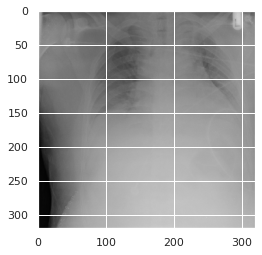

In [35]:
# ns.reset_defaults()

def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    for idx, path in enumerate(df.sample(100)["FilePath"].values):
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


image_paths = glob(data_dir1+'images_*/images/*.png')
image_one = image_paths[0]
print(image)
x = load_image(image_one, train_df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()

In [36]:
get_mean_std_per_batch(dataset)

(115.6761328125, 44.24512434171262)

In [37]:
import tensorflow as tf
import numpy as np
import cv2

def grad_cam(input_model, image, category_index, layer_name):
    """
    Grad-CAM method for visualizing input saliency.

    Args:
        input_model (Keras model): Model to compute Grad-CAM for.
        image (tensor): Input image tensor with shape (1, H, W, 3).
        category_index (int): Class index to compute Grad-CAM for.
        layer_name (str): Name of the layer to use for Grad-CAM.

    Returns:
        cam (numpy array): Grad-CAM heatmap for the input image.
    """
    # 1. Get the output tensor of the model and the specified layer
    model_output = input_model.output  # Model's output tensor
    y_c = model_output[0, category_index]  # Output for the specific class
    spatial_map_layer = input_model.get_layer(layer_name).output  # Output of the specified layer

    # 2. Compute gradients of the class output with respect to the layer's output
    grads = tf.GradientTape(y_c, spatial_map_layer)  # Gradients of y_c w.r.t. the layer's output

    # 3. Create a function to compute the spatial map and gradients
    compute_spatial_map_and_grads = tf.keras.backend.function(
        [input_model.input],  # Input to the model
        [spatial_map_layer, grads]  # Outputs: spatial map and gradients
    )

    # 4. Compute the spatial map and gradients for the input image
    spatial_map, grads_val = compute_spatial_map_and_grads([image])

    # Remove the batch dimension (shape: (H, W, C))
    spatial_map = spatial_map[0]
    grads_val = grads_val[0]

    # 5. Compute weights using global average pooling on gradients
    weights = np.mean(grads_val, axis=(0, 1))  # Shape: (C,)

    # 6. Compute the Grad-CAM heatmap
    cam = np.dot(spatial_map, weights)  # Shape: (H, W)

    # 7. Postprocess the heatmap
    cam = np.maximum(cam, 0)  # Apply ReLU to keep only positive values
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))  # Resize to input image size
    cam = cam / np.max(cam)  # Normalize to [0, 1]

    return cam

In [38]:
def compute_gradcam(model, img_path, mean, std ,df, 
                    labels, selected_labels, layer_name='conv5_block16_concat'):
    """
    Compute GradCAM for many specified labels for an image. 
    This method will use the `grad_cam` function.
    
    Args:
        model (Keras.model): Model to compute GradCAM for
        img (string): Image name we want to compute GradCAM for.
        mean (float): Mean to normalize to image.
        std (float): Standard deviation to normalize the image.
        data_dir (str): Path of the directory to load the images from.
        df(pd.Dataframe): Dataframe with the image features.
        labels ([str]): All output labels for the model.
        selected_labels ([str]): All output labels we want to compute the GradCAM for.
        layer_name: Intermediate layer from the model we want to compute the GradCAM for.
    """
    preprocessed_input = load_image_normalize(img_path, mean, std)
    predictions = model.predict(preprocessed_input)
    # print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(df[df["Index"] == img][labels].values[0]))[0]))

    plt.figure(figsize=(20, 15))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
    
    j = 1
    
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###    
    # Loop through all labels
    for i in range(len(labels)): # complete this line
        # Compute CAM and show plots for each selected label.
        
        # Check if the label is one of the selected labels
        if labels[i] in selected_labels: # complete this line
            
            # Use the grad_cam function to calculate gradcam
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            
            ### END CODE HERE ###
            
            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='magma', alpha=min(0.5, predictions[0][i]))
            j +=1


In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [42]:
model.save("chest_xray_model.h5")

In [43]:
from IPython.display import FileLink
FileLink('chest_xray_model.h5')  # or "chest_xray_model.pth"

/kaggle/working/chest_xray_model.h5

In [ ]:
import tensorflow as tf
print(tf.__version__)